In [9]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
import numpy as np

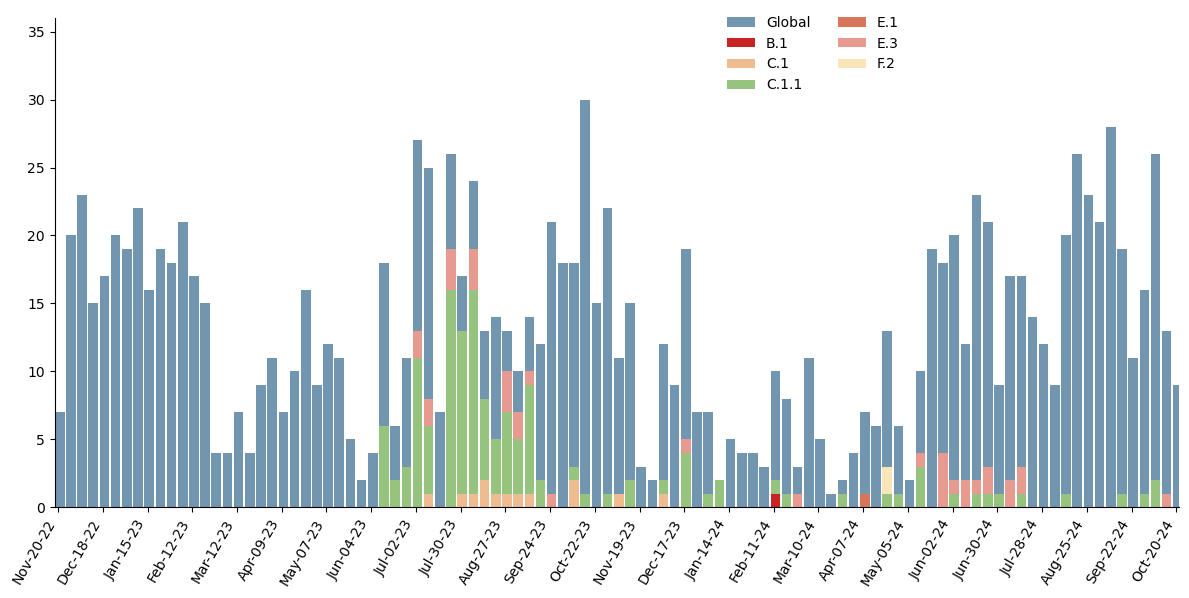

C.1.1: 2023-06-11
E.3: 2023-07-01
C.1: 2023-07-08
B.1: 2024-02-09
E.1: 2024-04-02
F.2: 2024-04-17


In [10]:
def plot_single_y_bar_charts(infections_tsv, metadata_tsv, output_svg):

    infections_df = pd.read_csv(infections_tsv, sep="\t")
    if "date" not in infections_df.columns:
        raise ValueError("Missing 'date' column in infections file")
    infections_df["date"] = pd.to_datetime(infections_df["date"])
    
    weekly_lineages = infections_df.groupby([pd.Grouper(key='date', freq='W-MON'), 'lineage']).size().unstack(fill_value=0)

    metadata_df = pd.read_csv(metadata_tsv, sep="\t")
    if "date" not in metadata_df.columns or "strain" not in metadata_df.columns:
        raise ValueError("Missing 'date' or 'strain' column in metadata file")
    metadata_df["date"] = pd.to_datetime(metadata_df["date"])
    weekly_metadata = metadata_df.resample("W-Mon", on="date")["strain"].size()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color_metadata = "#14517c"
    ax1.bar(
        weekly_metadata.index, 
        weekly_metadata, 
        color=color_metadata, 
        alpha=0.6, 
        label="Global", 
        width=6
    )

    lineage_colors = {
        'B.1': '#c82423',
        'C.1': '#efbc91',
        'C.1.1': '#96c37d',
        'E.1': '#d87659',
        'E.3': '#e79a90',
        'F.2': '#fae5b8',
    }

    colors = plt.cm.Set3(np.linspace(0, 1, len(weekly_lineages.columns)))

    bottom = np.zeros(len(weekly_lineages))
    for lineage in weekly_lineages.columns:
        color = lineage_colors.get(lineage, '#999999')
        ax1.bar(
            weekly_lineages.index,
            weekly_lineages[lineage],
            bottom=bottom,
            color=color,
            alpha=1,
            label=lineage,
            width=6
        )
        bottom += weekly_lineages[lineage]
    
    ax1.tick_params(axis="y", labelcolor="#000000")
    ax1.set_ylim(0, 36)
    ax1.yaxis.set_major_locator(plt.MultipleLocator(5))

    x_min = metadata_df["date"].min()
    x_max = metadata_df["date"].max()
    ax1.set_xlim(x_min, x_max)

    xticks = pd.date_range(start=x_min, end=x_max, freq="4W")
    xticklabels = [date.strftime("%b-%d-%y") for date in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticklabels, rotation=60, ha="right")

    fig.legend(loc="upper left", bbox_to_anchor=(0.6, 1), frameon=False, ncol=2)

    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.grid(False)

    plt.savefig(output_svg, format="svg", bbox_inches='tight')

    plt.tight_layout()
    plt.show()

    lineages_first_appear = infections_df.groupby("lineage")["date"].min().sort_values()
    for lineage, date in lineages_first_appear.items():
        print(f"{lineage}: {date.strftime('%Y-%m-%d')}")

infections_tsv = "good_sequences.tsv"
metadata_tsv = "global.tsv"
output_svg = "fig/global_infection.svg"

plot_single_y_bar_charts(infections_tsv, metadata_tsv, output_svg)

/tmp/ipykernel_67729/2868067340.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


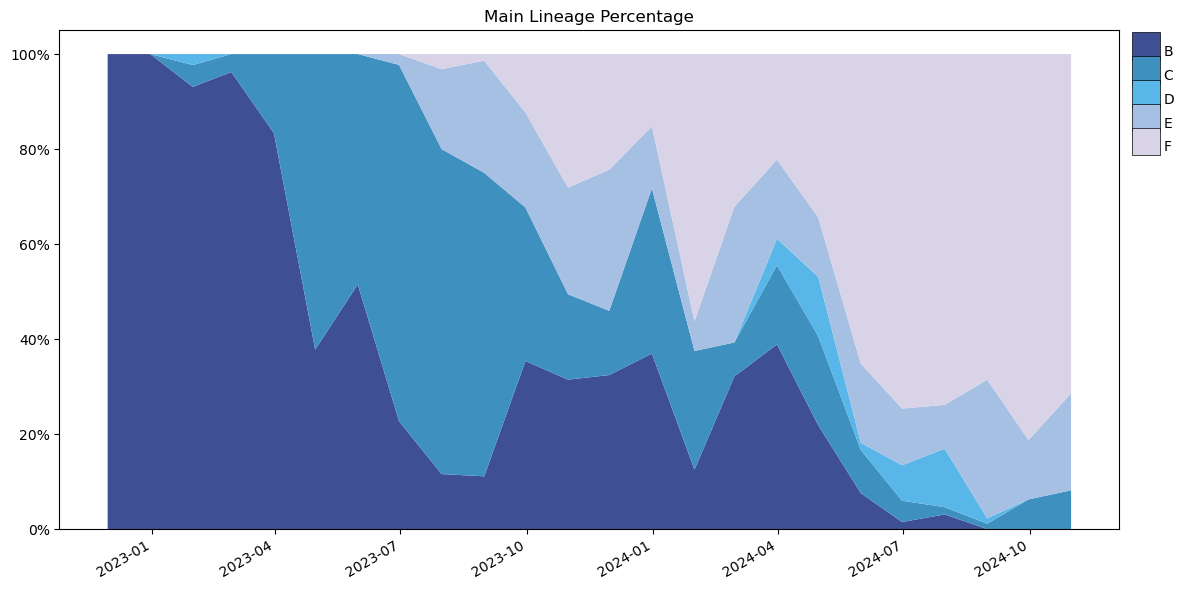

In [11]:
def extract_main_lineage(lineage):
    if pd.isna(lineage) or lineage == "":
        return "Unknown"
    return lineage.split(".")[0]


def plot_lineage_monthly_main_branch_stackplot(tsv_file, output_plot, colors=None):
    df = pd.read_csv(tsv_file, sep="\t")

    if "lineage" not in df.columns or "date" not in df.columns:
        raise ValueError("Missing 'lineage' or 'date' column")

    df["main_lineage"] = df["lineage"].apply(extract_main_lineage)
    df["date"] = pd.to_datetime(df["date"])

    df_grouped = df.groupby([pd.Grouper(key="date", freq="M"), "main_lineage"]).size().unstack(fill_value=0)
    df_percentage = df_grouped.div(df_grouped.sum(axis=1), axis=0)

    months = df_percentage.index
    main_lineages = df_percentage.columns

    if colors is None:
        colors = ["#4e1945", "#8d2f25", "#cb9475", "#8cbf87", "#3e608d"]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.stackplot(months, df_percentage.T, labels=main_lineages, colors=colors)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    legend = ax.legend(
        loc="upper left",
        bbox_to_anchor=(1.0, 1.0),
        handlelength=1.5,
        handleheight=1.5,
        frameon=False
    )

    for handle in legend.legendHandles:
        handle.set_height(20)
        handle.set_width(20)
        handle.set_edgecolor("black")
        handle.set_linewidth(0.5)

    ax.set_title("Main Lineage Percentage")
    fig.autofmt_xdate()

    plt.savefig(output_plot, bbox_inches="tight")
    plt.tight_layout()
    plt.show()


tsv_file = "global.tsv"
output_plot = "fig/lineage_monthly.svg"
custom_colors = ["#3e4f94", "#3e90bf", "#58b6e9", "#a6c0e3", "#d8d3e7"]

plot_lineage_monthly_main_branch_stackplot(tsv_file, output_plot, colors=custom_colors)

In [ ]:
tsv_file = "Shenzhen/global.tsv"
df = pd.read_csv(tsv_file, sep="\t")

if "strain" not in df.columns:
    raise ValueError("The TSV file must contain a 'strain' column.")

def extract_date(strain):
    try:
        date_str = strain.split("|")[-1]
        return datetime.strptime(date_str, "%Y-%m-%d")
    except (IndexError, ValueError):
        return None

df["date"] = df["strain"].apply(extract_date)
df = df.dropna(subset=["date"])

earliest_date = df["date"].min()
latest_date = df["date"].max()
total_sequences = len(df)

print(f"Total number of sequences: {total_sequences}")
print(f"Earliest date: {earliest_date.strftime('%Y-%m-%d')}")
print(f"Latest date: {latest_date.strftime('%Y-%m-%d')}")



Total number of sequences: 1129
Earliest date: 2022-11-18
Latest date: 2024-10-22
